# Ticket inspection AI

## Imports

In [1]:
import re
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import optuna as opt

/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
def strCleaner(x: str) -> str:
    x = x.lower()
    x = x.replace(" ", "_")
    return x


def clockTofloat(x: str) -> float:
    x = x[:-3]
    x = x.replace(":",".")
    x = float(x)
    return x

def findCatCode(l, x: str) -> int:
    for i in range(len(l)):
        if l[i] == x:
            code = l.codes[i]
            return code
        
def datetimeToInt(dt) -> int:
    # second = dt.second+0
    minute = dt.minute #+100
    hour = dt.hour*100 #00
    day = dt.day*10000 #00
    month = dt.month*1000000 #00
    year = dt.year*100000000 #00
    
    ret = minute+hour+day+month+year
    return ret
    

## Reading data

In [3]:
db = pd.read_excel("/Users/sigurdskyrud/OneDrive/Dokumenter/Andre Dokumenter/Billettkontroll data.xlsx")
db.head(2)

,Linje,Vogn,Dato,Klokke,Fra,Til,Fullt?,Sjekket?,Merknad
0,L12,Fremst,2022-09-25,11:30:00,Eidsvoll,Oslo Lufthavn,Nei,Nei,NaN
1,R10,Bakerst,2022-09-25,21:59:00,Oslo Lufthavn,Eidsvoll,Ja,Ja,NaN


In [4]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     44 non-null     object        
 1   Vogn      44 non-null     object        
 2   Dato      44 non-null     datetime64[ns]
 3   Klokke    44 non-null     object        
 4   Fra       44 non-null     object        
 5   Til       44 non-null     object        
 6   Fullt?    44 non-null     object        
 7   Sjekket?  44 non-null     object        
 8   Merknad   3 non-null      object        
dtypes: datetime64[ns](1), object(8)
memory usage: 3.2+ KB


## Categorize the columns

In [5]:
db["Fullt?"] = db["Fullt?"].apply(lambda x: strCleaner(x))
fulltCat = pd.Categorical(db["Fullt?"])
db["Fullt?"] = pd.Categorical(db["Fullt?"]).codes

db["Sjekket?"] = db["Sjekket?"].apply(lambda x: strCleaner(x))
sjekketCat = pd.Categorical(db["Sjekket?"])
db["Sjekket?"] = pd.Categorical(db["Sjekket?"]).codes

db["Linje"] = db["Linje"].apply(lambda x: strCleaner(x))
linjeCat = pd.Categorical(db["Linje"])
db["Linje"] = pd.Categorical(db["Linje"]).codes

db["Fra"] = db["Fra"].apply(lambda x: strCleaner(x))
fraCat = pd.Categorical(db["Fra"])
db["Fra"] = pd.Categorical(db["Fra"]).codes

db["Til"] = db["Til"].apply(lambda x: strCleaner(x))
tilCat = pd.Categorical(db["Til"])
db["Til"] = pd.Categorical(db["Til"]).codes

In [6]:
db["Vogn"] = pd.Series(db["Vogn"], dtype="string")
db["Vogn"] = db["Vogn"].apply(lambda x: strCleaner(x))

vognCat = pd.Categorical(db["Vogn"])
db["Vogn"] = pd.Categorical(db["Vogn"]).codes

In [7]:
db["Merknad"].fillna(-1)

merknadCat = pd.Categorical(db["Merknad"])
db["Merknad"] = pd.Categorical(db["Merknad"]).codes

Sets date to integer

In [8]:
# db['Dato'] = (db['Dato'] - db['Dato'].min())  / np.timedelta64(1,'D')
# db["Dato"] = db["Dato"].apply(lambda x: datetimeToInt(x))
# db["Dato"]

Sets the time in int format

In [9]:
db["Klokke"] = pd.Series(db["Klokke"], dtype="str")
db["Klokke"] = db["Klokke"].apply(lambda x: clockTofloat(x))

In [10]:
fraCat

['eidsvoll', 'oslo_lufthavn', 'eidsvoll', 'nationaltheatret', 'eidsvoll', ..., 'nationaltheatret', 'eidsvoll', 'oslo_lufthavn', 'eidsvoll', 'oslo_lufthavn']
Length: 44
Categories (5, object): ['eidsvoll', 'nationaltheatret', 'oslo_lufthavn', 'oslo_s', 'skarnes']

In [11]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Linje     44 non-null     int8          
 1   Vogn      44 non-null     int8          
 2   Dato      44 non-null     datetime64[ns]
 3   Klokke    44 non-null     float64       
 4   Fra       44 non-null     int8          
 5   Til       44 non-null     int8          
 6   Fullt?    44 non-null     int8          
 7   Sjekket?  44 non-null     int8          
 8   Merknad   44 non-null     int8          
dtypes: datetime64[ns](1), float64(1), int8(7)
memory usage: 1.1 KB


<AxesSubplot:>

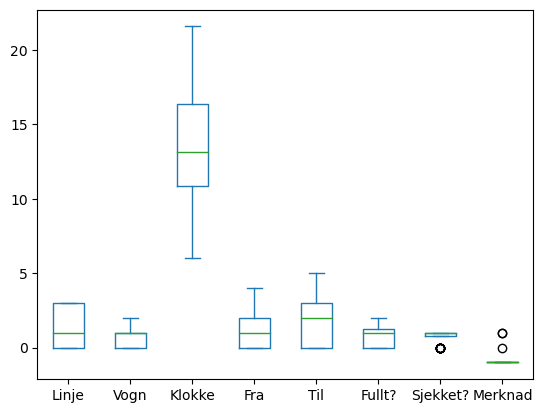

In [12]:
db.plot.box()

## Creating testing data

In [13]:
# Create the data to create predict from
X = db.drop(["Sjekket?"], axis=1)

# Create the data to predict to
y = db["Sjekket?"]

In [14]:
# My data has too few entries, date becomes to dominant
X = X.drop(["Dato"], axis=1)

# Merknad has gives no impact on result
X = X.drop(["Merknad"], axis=1)

### Testing without clock
# X = X.drop(["Klokke"], axis=1)

In [15]:
X.head(3)

,Linje,Vogn,Klokke,Fra,Til,Fullt?
0,0,1,11.30,0,3,1
1,2,0,21.59,2,0,0
2,0,1,9.30,0,2,0


In [16]:
# Split the data into train and test sets with test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating model1

In [17]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

[23:14:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
preds = model.predict(X_test)

### Model 1's confusion matrix

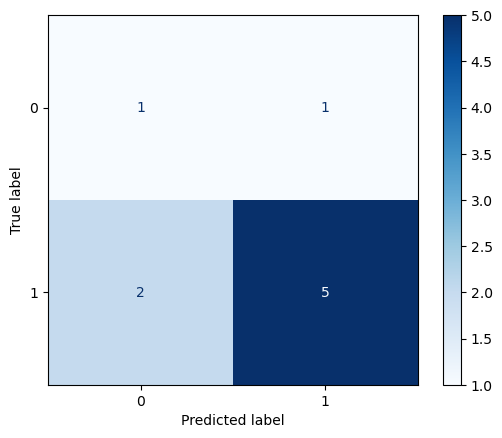

In [19]:
cm = confusion_matrix(y_true=y_test, y_pred=preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

In [20]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds)
print(f"Accuracy: {accuracy * 100.0 : .2f}")

Accuracy:  66.67


### Model 1's feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

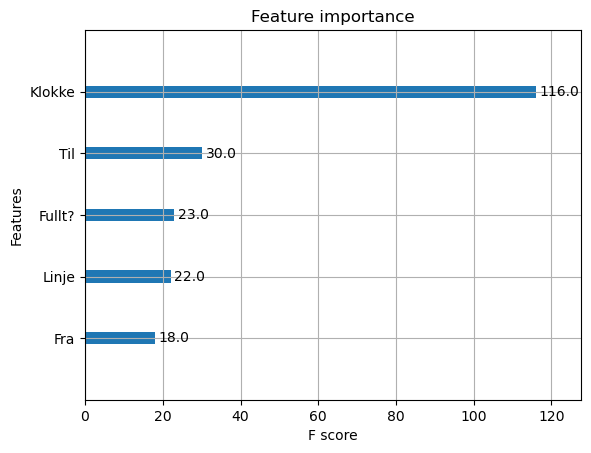

In [21]:
xgb.plot_importance(model)

## Creating model 2

In [22]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_test)

    # Evaluate predictions
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = opt.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

[I 2022-12-01 23:14:30,051] A new study created in memory with name: no-name-518ea7a0-0eaa-4777-92a6-ef13705410c9
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_20885/4244495913.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_20885/4244495913.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
/var/folders/6s/94cj8dh53f76lqyqy2psnzcr0000gn/T/ipykernel_20885/4244495913.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

In [23]:
bparams = study.best_params
model2 = xgb.XGBClassifier(**bparams)
model2.fit(X_train, y_train)

[23:14:59] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/intro-ai/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.04336982615582685,
              enable_categorical=False, gamma=0.00993902183000276, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.24233653050216888, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=67, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=5.572994890105415e-08,
              reg_lambda=6.932136046016573e-07, scale_pos_weight=1,
              subsample=0.8851569336840723, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [24]:
preds2 = model2.predict(X_test)

## Model 2 testing

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

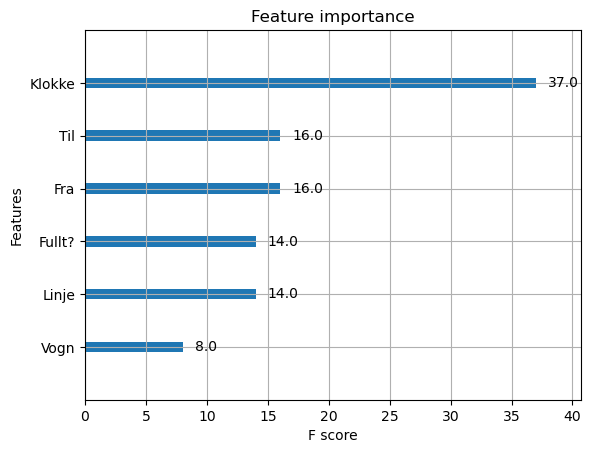

In [25]:
xgb.plot_importance(model2)

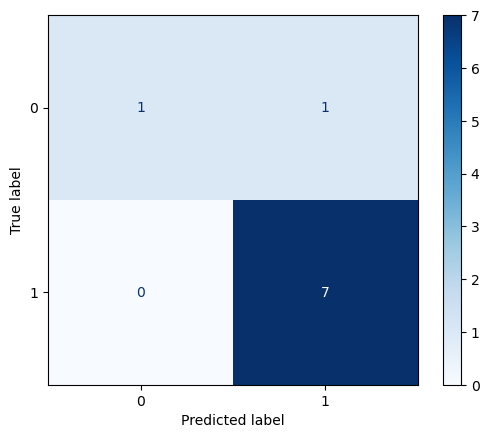

In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=preds2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

disp.plot(cmap='Blues')

In [27]:
accuracy = accuracy_score(y_true=y_test, y_pred=preds2)
print(f"Accuracy: {accuracy * 100.0 : .2f}")

Accuracy:  88.89


# Self testing

In [28]:
X_test

,Linje,Vogn,Klokke,Fra,Til,Fullt?
37,1,2,21.08,4,1,1
24,3,1,13.00,0,3,1
25,0,0,20.19,2,0,1
36,3,0,16.18,1,0,0
34,0,0,14.19,2,0,1
40,3,1,11.00,0,3,1
4,3,1,6.00,0,3,1
12,3,2,16.18,1,0,0
8,0,2,12.48,1,0,0


In [29]:
y_test

37    1
24    1
25    1
36    1
34    1
40    0
4     0
12    1
8     1
Name: Sjekket?, dtype: int8

In [35]:
tester = X_test
tester = tester.drop(X_test.index)
tester

# Parameters
linje = "r10"
vogn = "fremst"
# dato = 20221011
klokke = 14.35
fra = "nationaltheatret"
til = "eidsvoll"
fullt = "ja"

data = {"Linje": [findCatCode(linjeCat, linje)], 
          "Vogn": [findCatCode(vognCat, vogn)],
          "Klokke": [klokke], 
          "Fra": [findCatCode(fraCat, fra)], 
          "Til": [findCatCode(tilCat, til)], 
         "Fullt?": [findCatCode(fulltCat, fullt)]}

testdb = pd.DataFrame(data)

tester = pd.concat([tester, testdb])
tester


,Linje,Vogn,Klokke,Fra,Til,Fullt?
0,0,1,14.35,1,0,0


In [36]:
# Finds what the number means
ja = findCatCode(sjekketCat, 'ja')
nei = findCatCode(sjekketCat, 'nei')

print(f"Nei = {nei}\n"+
      f"Ja = {ja}")

testpred = model.predict(tester)
print(testpred)

if testpred[0] == ja:
    print("Ja, det er en sannsynlighet")
else:
    print("Nei, det er liten sannsynlighet")

Nei = 1
Ja = 0
[1]
Nei, det er liten sannsynlighet
